# 5. Influence factors: Vineyard management on berry microbiome

In [6]:
#!mkdir /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/influence/plot-properties

In [7]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/influence/plot-properties'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/influence/plot-properties


In [8]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [9]:
from qiime2 import Visualization
import qiime2 as q2
from qiime2 import Visualization
from qiime2 import Artifact
from qiime2 import Metadata
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2.plugins.diversity.visualizers import alpha_group_significance
from qiime2.plugins.feature_table.methods import (filter_samples, filter_seqs)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
import numpy as np

from qiime2.plugins import diversity as q2d

%matplotlib inline

# Colinearity between variables

In [13]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv', sep='\t')
md_df.head()

,id,SAMPLE_NAME,sample_type,Plot_ID,COLLECTION_DATE,Year,Year_Cat,Plot,Altitude,Average_slope,...,Quadrant,Cluster,Plot_PCA_kMeans_Cluster,Phenology_BudBreak,Phenology_Flowering,Hail_Damage,Herbicide,Mildew,Grape_Yield_Estimate,Pruning_Weight
0,364526_290-LP3-ITS-0866,Lavaux_2021-08-31_bark_Plot4,bark,Lavaux_Plot_4,2021-08-31 00:00:00 +0200,2021,Year2021,4,450,30,...,NW,Cluster3,Cluster1,105,170,no,band,yes,medium,49.71
1,364526_289-LP3-ITS-0865,Lavaux_2021-08-31_bark_Plot5,bark,Lavaux_Plot_5,2021-08-31 00:00:00 +0200,2021,Year2021,5,400,30,...,SW,Cluster3,Cluster3,104,167,no,band,no,medium,57.41
2,364526_285-LP3-ITS-0861,Lavaux_2021-08-31_bark_Plot9,bark,Lavaux_Plot_9,2021-08-31 00:00:00 +0200,2021,Year2021,9,520,35,...,NE,Cluster3,Cluster2,111,172,no,almost_total,yes,low,38.99
3,364526_287-LP3-ITS-0863,Lavaux_2021-08-31_bark_Plot11,bark,Lavaux_Plot_11,2021-08-31 00:00:00 +0200,2021,Year2021,11,490,20,...,NW,Cluster3,Cluster1,109,173,yes,band,yes,low,47.67
4,364526_282-LP3-ITS-0858,Lavaux_2021-08-31_bark_Plot12,bark,Lavaux_Plot_12,2021-08-31 00:00:00 +0200,2021,Year2021,12,520,15,...,NW,Cluster1,Cluster1,107,173,no,almost_total,yes,medium,54.09


In [18]:
md_plots_subset = md_df[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation']]

categorical_cols = ['Exposition']
md_plots_subset_dummies = pd.get_dummies(md_plots_subset, columns=categorical_cols, drop_first=True)
boolean_columns = md_plots_subset_dummies.select_dtypes(include='bool').columns
md_plots_subset_dummies[boolean_columns] = md_plots_subset_dummies[boolean_columns].astype(int)

md_plots_subset_dummies.head()

,Altitude,Average_slope,Average_radiation,Exposition_South-West
0,450,30,937.5,1
1,400,30,912.5,1
2,520,35,887.5,1
3,490,20,937.5,0
4,520,15,937.5,1


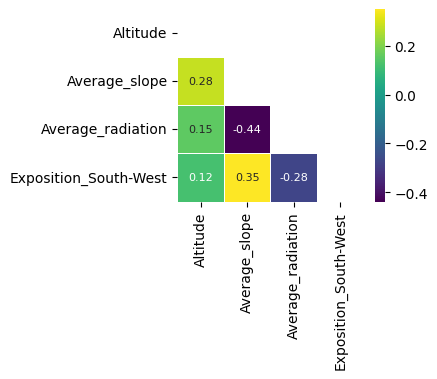

In [29]:
# Compute and visualize correlation
cor_matrix = md_plots_subset_dummies.corr()

# Mask the upper triangle for clarity
mask = np.triu(np.ones_like(cor_matrix, dtype=bool))

# Set masked values to NaN for annotations
annot_matrix = cor_matrix.mask(mask)

# Create the heatmap
plt.figure(figsize=(3,2.5))
sns.heatmap(cor_matrix, mask=mask, annot=annot_matrix, cmap='viridis',annot_kws={'size': 8}, fmt='.2f', cbar=True, linewidths=0.5)
plt.show()

In [22]:
# Create a contingency table
contingency_table = pd.crosstab(md_plots_subset_dummies['Average_slope'], md_plots_subset_dummies['Average_radiation'])

# Perform the Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:\n", expected)

Chi-Square Statistic: 770.1798718773645
p-value: 5.298171464528013e-159
Degrees of Freedom: 10
Expected Frequencies Table:
 [[  4.54285714  25.62857143  20.82857143]
 [ 14.60840336  82.41344538  66.97815126]
 [  6.41344538  36.18151261  29.40504202]
 [ 19.24033613 108.54453782  88.21512605]
 [  4.7210084   26.63361345  21.64537815]
 [  3.47394958  19.59831933  15.92773109]]


# Must 

In [23]:
%%bash 

# Core diversity metrics
qiime diversity core-metrics \
        --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_table.qza \
        --p-sampling-depth 10000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-n-jobs 5 \
        --output-dir cm10000/

# Kmer diversity
qiime kmerizer core-metrics \
        --i-sequences /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_rep_seqs.qza \
        --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_table.qza \
        --p-sampling-depth 10000 \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-n-jobs auto \
        --output-dir kmer_cm10000/


Saved FeatureTable[Frequency] to: cm10000/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: cm10000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: cm10000/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: cm10000/evenness_vector.qza
Saved DistanceMatrix to: cm10000/jaccard_distance_matrix.qza
Saved DistanceMatrix to: cm10000/bray_curtis_distance_matrix.qza
Saved PCoAResults to: cm10000/jaccard_pcoa_results.qza
Saved PCoAResults to: cm10000/bray_curtis_pcoa_results.qza
Saved Visualization to: cm10000/jaccard_emperor.qzv
Saved Visualization to: cm10000/bray_curtis_emperor.qzv
Saved FeatureTable[Frequency] to: kmer_cm10000/rarefied_table.qza
Saved FeatureTable[Frequency] to: kmer_cm10000/kmer_table.qza
Saved SampleData[AlphaDiversity] to: kmer_cm10000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: kmer_cm10000/shannon_vector.qza
Saved DistanceMatrix to: kmer_cm10000/jaccard_distance_matrix.qza
Saved DistanceMatrix to: kmer_cm10000/bray_cur

## Alpha Diversity

In [25]:
alpha_metrics = ['shannon_vector', 'observed_features_vector', 'evenness_vector']

output_dir = 'cm10000'

for metric in alpha_metrics:
    !qiime diversity alpha-group-significance \
        --i-alpha-diversity {output_dir}/{metric}.qza \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --o-visualization {output_dir}/alpha_groupSig_{metric}.qzv

Saved Visualization to: cm10000/alpha_groupSig_shannon_vector.qzv
Saved Visualization to: cm10000/alpha_groupSig_observed_features_vector.qzv
Saved Visualization to: cm10000/alpha_groupSig_evenness_vector.qzv


In [26]:
Visualization.load('cm10000/alpha_groupSig_evenness_vector.qzv')

<visualization: Visualization uuid: 98ad04df-212c-4596-a100-962fcf22284a>

In [27]:
Visualization.load('cm10000/alpha_groupSig_observed_features_vector.qzv')

<visualization: Visualization uuid: 2d1fbe9a-e6e9-4a4b-a2f0-dcc27343ae8f>

In [28]:
Visualization.load('cm10000/alpha_groupSig_shannon_vector.qzv')

<visualization: Visualization uuid: dcc434d3-12d0-4edf-82f7-1d67738885cb>

### PERMANOVA thereof

In [31]:
formula='Altitude + Average_slope + Exposition'

beta_metrics = ['bray_curtis', 'jaccard']

# PERMANOVA with core metrics 
div_dir = 'cm10000'
for m in beta_metrics:
    !qiime diversity adonis \
        --i-distance-matrix "{div_dir}/{m}_distance_matrix.qza" \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-formula "{formula}" \
        --p-n-jobs 5 \
        --o-visualization "{div_dir}/adonis_{m}.qzv"

# PERMANOVA with kmer core metrics 
kmer_dir = 'kmer_cm10000'
for m in beta_metrics:
    !qiime diversity adonis \
        --i-distance-matrix "{kmer_dir}/{m}_distance_matrix.qza" \
        --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv \
        --p-formula "{formula}" \
        --p-n-jobs 5 \
        --o-visualization "{kmer_dir}/adonis_{m}.qzv"

Saved Visualization to: cm10000/adonis_bray_curtis.qzv
Saved Visualization to: cm10000/adonis_jaccard.qzv
Saved Visualization to: kmer_cm10000/adonis_bray_curtis.qzv
Saved Visualization to: kmer_cm10000/adonis_jaccard.qzv


In [32]:
Visualization.load('cm10000/adonis_bray_curtis.qzv')

<visualization: Visualization uuid: 40bdafee-f68f-4da7-b71f-0a917a928028>

In [33]:
Visualization.load('cm10000/adonis_jaccard.qzv')

<visualization: Visualization uuid: bfff2b86-0c83-4ccc-95c4-2e474386187f>

In [34]:
Visualization.load('kmer_cm10000/adonis_bray_curtis.qzv')

<visualization: Visualization uuid: d913d56e-3e73-441f-9645-d56c8f3c7afd>

In [35]:
Visualization.load('kmer_cm10000/adonis_jaccard.qzv')

<visualization: Visualization uuid: cf18da7f-86e1-471b-9dc0-2fa24a0ee44a>